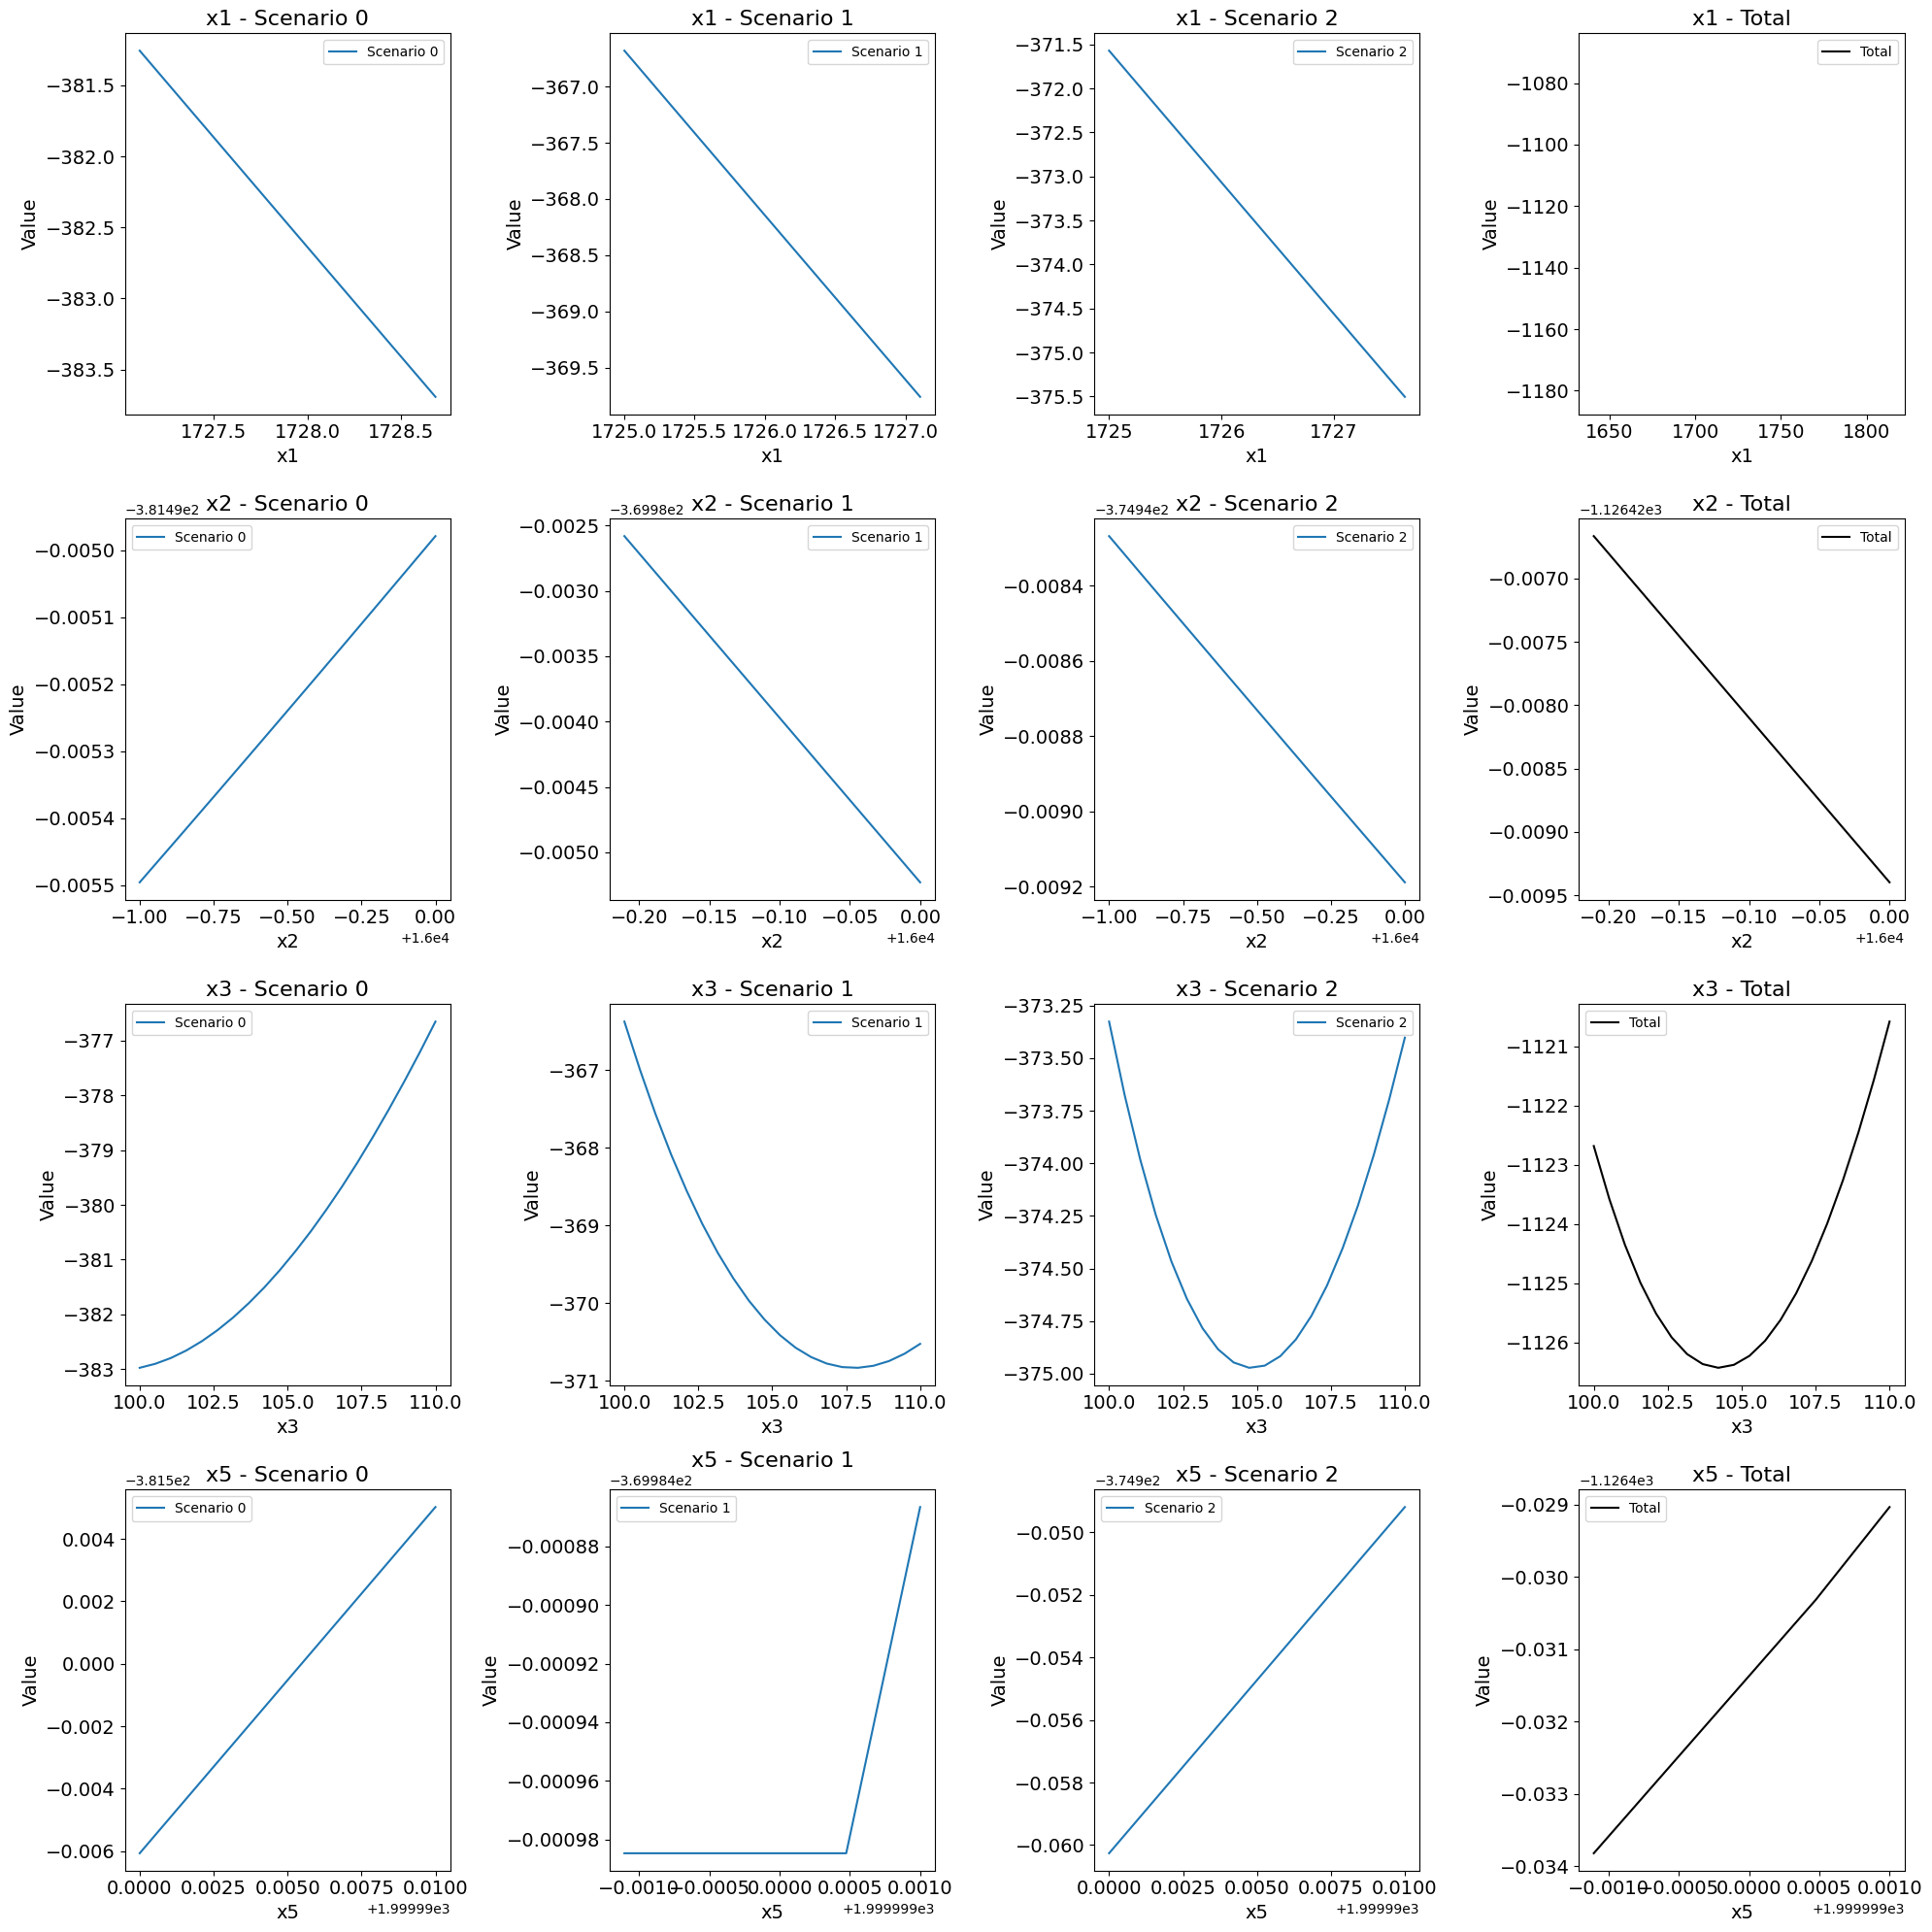

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from pyomo.opt import SolverFactory, TerminationCondition
from src.analyses.value_function import ValueFunction
from src.analyses.convergence_analysis import HausdorffAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from scipy.optimize import curve_fit
from NSPLIB.src.instances.process.process_SP import const_model
import copy
# Constants
process_obj = -1126.4218270121305
process_sol = {"x1":1727.2601809997955,"x2":16000,"x3":104.23841082714829,"x5":2000}
process_y_bound = {"x1":[10,2000],"x2":[0,16000],"x3":[0,120],"x5":[0,2000]}
process_y_bound = {"x1":[1725,1730],"x2":[15999,16000],"x3":[100,110],"x5":[1999.99,2000]}
# Build model
sto_m = const_model()
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()

v_f= ValueFunction(m,solver="baron")
y_dimension = {'x1':{}, 'x2':{}, 'x3':{}, 'x5':{}}
steps=20
for y in y_dimension.keys():
    v_f.calc_1D(idx=y, y_val_fix=copy.deepcopy(process_sol),
                    interval=process_y_bound[y], step=steps)
    for s in m.scenarios:
        y_dimension[y][s] = v_f.value_func[s]
    y_dimension[y]['total'] = v_f.total_value_func


fig, axs = plt.subplots(
    nrows=len(y_dimension), 
    ncols=len(m.scenarios) + 1, 
    figsize=(5 * (len(m.scenarios) + 1), 5 * len(y_dimension))
)
for row_idx, (y_key, y_data) in enumerate(y_dimension.items()):
    for col_idx, s in enumerate(m.scenarios):
        ax = axs[row_idx, col_idx] if len(y_dimension) > 1 else axs[col_idx]
        ax.plot(
            np.linspace(*process_y_bound[y_key], steps), 
            y_data[s], 
            label=f"Scenario {s}"
        )
        ax.set_title(f"{y_key} - Scenario {s}", fontsize=16)
        ax.set_xlabel(y_key, fontsize=14)
        ax.set_ylabel("Value", fontsize=14)
        ax.tick_params(axis='both', labelsize=14)
        ax.legend()
    # Plot total in the last column
    ax = axs[row_idx, -1] if len(y_dimension) > 1 else axs[-1]
    ax.plot(
        np.linspace(*process_y_bound[y_key], steps), 
        y_data['total'], 
        label="Total", color='black'
    )
    ax.set_title(f"{y_key} - Total", fontsize=16)
    ax.set_xlabel(y_key, fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend()

plt.tight_layout()
plt.show()